In [1]:
#proj5 Victor Zhang
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn
from scipy.stats import multivariate_normal
import scipy.stats as stats

#calc likelihood for convergence test
def gmm_llh(X, weight, mean, var):
    llh = 0
    for w, mu, sig in zip(weight, mean, var):
        norm_k = multivariate_normal(mean=mu, cov=sig)
        llh += w * norm_k.pdf(X)
    return np.sum(np.log(llh))

# gamma get Gaussian Dis
def comp_r(k, weight, mean, var):
    gaus = [multivariate_normal(mean=mean_i, cov=var_i) for mean_i, var_i in zip(mean, var)]
    def r(x):
        g_list = [w_i * n.pdf(x) for w_i, n in zip(weight, gaus)]
        return g_list[k] / np.sum(g_list, axis=0)
    return r
#equ 6.23
def E(weight, mean, var):
    res = []
    for i, _ in enumerate(mean):
        r = comp_r(i, weight, mean, var)
        res.append(r)
    return res

#equ 6.24-6.27
def M(X, res):
    X_len = len(X)
    weight, mean, var = [], [], []
    for r in res:
        r = r(X)
        r_sum = r.sum()
        #9.24
        mean_i = (r[:, np.newaxis] * X).sum(axis=0) / r_sum
        #9.25
        var_i = r[:, np.newaxis, np.newaxis] * np.einsum("ij, ik->ikj", (X - mean_i), (X - mean_i))
        var_i = var_i.sum(axis=0) / r_sum
        #9.26
        w_i = r_sum / X_len

        weight.append(w_i)
        mean.append(mean_i)
        var.append(var_i)
    return mean, var, weight

def my_2dplot(X, mean, var, r, title):
    diff=0.05
    colors = ["red", "blue"]
    xmin, ymin = X.min(axis=0)
    xmax, ymax = X.max(axis=0)
    xx, yy = np.mgrid[xmin:xmax:diff, ymin:ymax:diff]

    gaus = [multivariate_normal(mean=mean_i, cov=var_i)
             for mean_i, var_i in zip(mean, var)]

    for Gau_d, color in zip(gaus, colors):
        prob = Gau_d.pdf(np.c_[xx.flatten(), yy.flatten()]).reshape(xx.shape)
        plt.contour(xx, yy, prob, levels=1, colors=color)

    plt.scatter(*X.T, alpha=0.7, c=r[0](X), cmap="bwr")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel("eruptions")
    plt.ylabel("waiting")
    plt.title(title)
    plt.show()

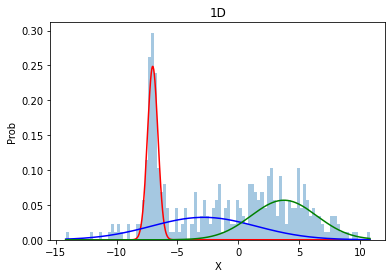

In [2]:
#generate 1D data
np.random.seed(767442)
X=np.concatenate((np.random.normal(0, 5, 200),np.random.normal(5, 2,50),np.random.normal(-7, 0.5, 100)))
X = X.reshape((len(X),1))
X_len = len(X)

# Initialize
weight = [0.3, 0.4, 0.3]
mean = [1, 2, 3]
var = [1, 1, 1]

# follow 9.23-9.28
threshold = 1e-8
count = 0 #for forcing first iteration
while True:
    res = E(weight, mean, var)

    mean, var, weight = M(X, res)
    llh = gmm_llh(X, weight, mean, var)

    if count > 2 and np.abs(llh / prev - 1) < threshold:
        break
    prev = llh
    count += 1

plt.hist(X, bins=100, density=True, alpha=0.4)

X_axis = np.linspace(np.amax(X), np.amin(X),1000)
plt.plot(X_axis,weight[0]*stats.norm.pdf(X_axis,mean[0],np.sqrt(var[0])).ravel(), c='red')
plt.plot(X_axis,weight[1]*stats.norm.pdf(X_axis,mean[1],np.sqrt(var[1])).ravel(), c='blue')
plt.plot(X_axis,weight[2]*stats.norm.pdf(X_axis,mean[2],np.sqrt(var[2])).ravel(), c='green')

plt.title("1D")
plt.xlabel("X")
plt.ylabel("Prob")
plt.show()

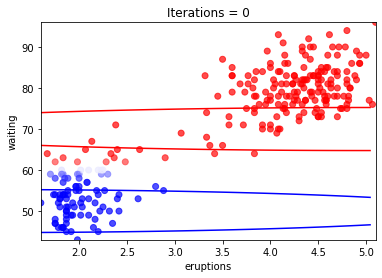

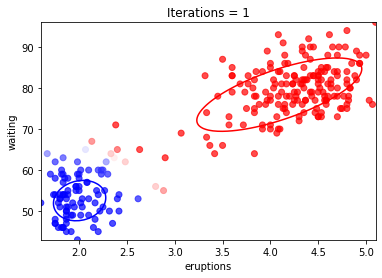

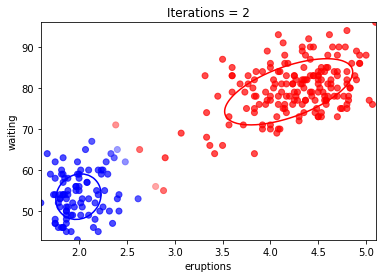

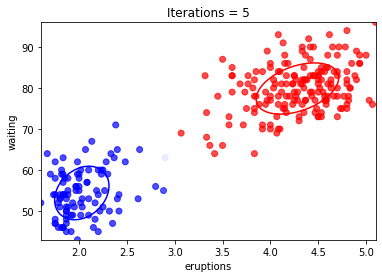

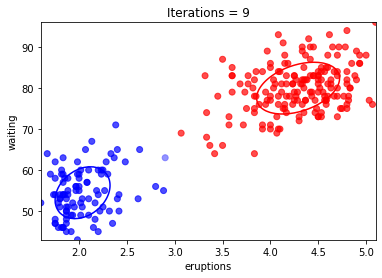

In [3]:
#load data from file
X=np.loadtxt(open("data.txt", "r"), delimiter="\t", skiprows=1) #data.txt is downloaded Old Faithful Dataset
X_len = len(X)

# Initial setup
mean1 = np.array([5, 70])
mean2 = np.array([ 1, 50])

var1 = np.identity(2) * 20
var2 = np.identity(2) * 20

weight = [0.5, 0.5]
mean = [mean1, mean2]
var = [var1, var2]

threshold = 1e-8
count = 0 #for forcing first iteration
while True:
    #E Step
    res = E(weight, mean, var)
    if count in [0,1,2,5,20]:
        my_2dplot(X, mean, var, res, "Iterations = {0}".format(count))

    #M Step
    mean, var, weight = M(X, res)
    #Check Likelihood
    llh = gmm_llh(X, weight, mean, var)
    if count > 2 and np.abs(llh / prev - 1) < threshold:
        break
    prev = llh
    count += 1

my_2dplot(X, mean, var, res, "Iterations = {0}".format(count))